In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import KFold

import random, os, json
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, GRU, Dropout, Dense
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

## Functions

In [24]:
from sklearn.metrics import confusion_matrix, roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def get_metrics_over_time(n_time_steps, y_test_df, y_pred_df):
    """
    Calculate metrics per time step.
    Args:
        - n_time_steps: Number of time steps.
        - y_test_df : DataFrame containing the real values.
        - y_pred_df : DataFrame containing the predicted values.
    Returns:
        - metrics_df: DataFrame containing the metrics for each time step.
    """
    mask = (y_test_df == 666)
    
    # Lists to store the metrics
    tn_list = []
    fp_list = []
    fn_list = []
    tp_list = []
    specificity_list = []
    recall_list = []
    roc_auc_list = []

    # Calculate the metrics for each time step
    for t in range(n_time_steps):
        # Filter the valid values according to the mask
        valid_indices = ~mask.iloc[:, t]
        y_test_valid = y_test_df.iloc[:, t][valid_indices]
        y_pred_valid = y_pred_df.iloc[:, t][valid_indices]

        # Round the predictions
        y_pred_rounded = np.round(y_pred_valid)

        # Calculate the confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test_valid, y_pred_rounded, labels=[0, 1]).ravel()

        # Calculate specifciity and recall
        specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
        recall = tp / (tp + fn) if (tp + fn) > 0 else np.nan

        # Calculate ROC-AUC
        roc = roc_auc_score(y_test_valid, y_pred_valid) if len(np.unique(y_test_valid)) > 1 else np.nan

        tn_list.append(tn)
        fp_list.append(fp)
        fn_list.append(fn)
        tp_list.append(tp)
        specificity_list.append(specificity)
        recall_list.append(recall)
        roc_auc_list.append(roc)

    # Dataframe to store the metrics per time step
    metrics_df = pd.DataFrame({
        'Time Step': range(1, n_time_steps+1),
        'TN': tn_list,
        'FP': fp_list,
        'FN': fn_list,
        'TP': tp_list,
        'Specificity': specificity_list,
        'Recall': recall_list,
        'ROC AUC': roc_auc_list
    })

    return metrics_df

def plot_metrics_over_time(metrics_df, T):
    """
    Plot metrics over time.
    Args:
        - metrics_df: DataFrame containing the metrics for each time step.
        - T: Number of time steps.
    """

    plt.figure(figsize=(12, 6))

    plt.plot(metrics_df['Time Step'], metrics_df['Specificity'], label='Specificity', marker='o')
    plt.plot(metrics_df['Time Step'], metrics_df['Recall'], label='Sensibility', marker='s')
    plt.plot(metrics_df['Time Step'], metrics_df['ROC AUC'], label='ROC-AUC', marker='^')    

    plt.legend()
    plt.xticks(ticks=range(1, T + 1))
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.show()
    
    
### SIMPLE BBCE ###

def create_simple_temp_weight(y, hyperparameters, timeSteps=14):
    """Create simple temporal weights for binary cross-entropy.
    Returns:
        ndarray: Sample weights.
    """
    
    sample_weights = y.copy()
    sample_weights[np.where(sample_weights == 1)] = 1
    sample_weights[np.where(sample_weights == 0)] = 1.515
    return sample_weights

def reset_keras(seed=42):
    """Function to ensure that results from Keras models
    are consistent and reproducible across different runs"""
    
    K.clear_session()
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed)
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    random.seed(seed)
    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed)
    # 4. Set `tensorflow` pseudo-random generator at a fixed value
    tf.random.set_seed(seed)


class GRUModel:
    """
    GRUModel class builds and trains a Gated Recurrent Unit (GRU) model
    with specified layers and hyperparameters.
    
    Attributes:
    -----------
    hyperparameters : dict
        A dictionary containing key hyperparameters for model building and training.
        
    Methods:
    --------
    build_model(lr_sch):
        Builds the GRU model with the specified learning rate scheduler.
    train(x_train, y_train, epochs, batch_size, validation_data):
        Trains the built model with the provided training and validation data.
    """
    
    def __init__(self, hyperparameters):
        """
        Initializes the GRUModel with hyperparameters.
        
        Parameters:
        -----------
        hyperparameters : dict
            A dictionary containing key hyperparameters for model building and training.
        """
        self.hyperparameters = hyperparameters
        
    def build_model(self, lr_sch):
        """
        Builds the GRU model with specified learning rate scheduler.
        
        Parameters:
        -----------
        lr_sch : float
            Learning rate for the optimizer during training.
            
        Returns:
        --------
        model : tf.keras.Model
            The compiled GRU model.
        """
        # Define input layer with dynamic shape and masking
        dynamic_input = tf.keras.layers.Input(shape=(self.hyperparameters["timeStep"], self.hyperparameters["layers"][0]))
        masked = tf.keras.layers.Masking(mask_value=self.hyperparameters['maskValue'])(dynamic_input)
        
        # Define GRU layer with specified parameters
        gru_encoder = tf.keras.layers.GRU(
            self.hyperparameters['layers'][1],
            dropout=self.hyperparameters['dropout'],
            return_sequences=True,
            activation='tanh',
            use_bias=True
        )(masked)

        # Define output layer with sigmoid activation function
        output = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, use_bias=False, activation="sigmoid"))(gru_encoder)
        
        # Compile the model with Adam optimizer and custom loss function
        model = tf.keras.Model(dynamic_input, [output])
        my_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_sch)
        model.compile(loss="binary_crossentropy",
                      optimizer=my_optimizer,
                      metrics=['accuracy', 'AUC']
                     )
        
        return model
        
    def train(self, x_train, y_train, x_val, y_val, w1, w2):
        """
        Trains the built model with provided training and validation data.
        
        Parameters:
        -----------
        x_train : numpy array
            Input training data.
        y_train : numpy array
            Target training data.
        epochs : int
            Number of training epochs.
        batch_size : int
            Batch size for training.
        validation_data : tuple
            Tuple containing input and target validation data.
        
        Returns:
        --------
        history : tf.keras.callbacks.History
            A record of training loss values and metrics values at successive epochs.
        model : tf.keras.Model
            The trained GRU model.
        """
        
        model = self.build_model(lr_sch=self.hyperparameters['lr_scheduler'])
        earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      min_delta=self.hyperparameters["mindelta"],
                                                      patience=self.hyperparameters["patience"],
                                                      restore_best_weights=True,
                                                      mode="min")
                    
        history = model.fit(x_train, y_train,
                            validation_data=(x_val, y_val, w2.squeeze()),
                            callbacks=[earlystopping],
                            batch_size=self.hyperparameters['batch_size'], 
                            epochs=self.hyperparameters['epochs'],
                            verbose=1,
                            sample_weight = w1.squeeze())

        return history, model
    
    
def myCVGrid(hyperparameters, seed, X_train, y_train):
    """Grid Search. Calculate metricDev based on the evaluation. Compares the metricDev with the current bestMetricDev. 
       If better, updates bestMetricDev and stores those hyperparameters in bestHyperparameters.
       
       Returns:
          - bestHyperparameters (dict)
          - X_train, X_val, y_train, y_val (arrays): Training and validation datasets.
          - v_early (list): Early stopping information for each hyperparameter combination.
          - v_hist (list): Training history for each hyperparameter combination.
    """
    
    
    bestHyperparameters = {'dropout': -1, 'layers': -1, 'lr_scheduler':-1}
    bestMetricDev = -np.inf
    
    
    lr_scheduler = hyperparameters["lr_scheduler"]
    layers = hyperparameters["layers"]
    dropout = hyperparameters["dropout"]
    
    for k in range(len(dropout)):
        for l in range(len(layers)):
            for m in range(len(lr_scheduler)):
                hyperparameters = {
                    'timeStep': hyperparameters["timeStep"],
                    'maskValue': hyperparameters["maskValue"],
                    'batch_size': hyperparameters["batch_size"],
                    'epochs': hyperparameters["epochs"],
                    'monitor':  hyperparameters["monitor"],
                    "mindelta": hyperparameters["mindelta"],
                    "patience": hyperparameters["patience"],
                    "kfold": hyperparameters["kfold"],
                    
                    "dropout": dropout[k],
                    "layers": layers[l],
                    "lr_scheduler": lr_scheduler[m],
                
                    'verbose': 0
                }
                v_metric_dev = []
                v_hist = []
                v_val_loss = []
                print("\t\tLearning rate:", lr_scheduler[m], ", dropout:", dropout[k], ", layers:", layers[l])

               
                all_patients_train = X_train.shape[0]
                kf = KFold(n_splits=hyperparameters["kfold"], shuffle=True, random_state=seed)
                kf.get_n_splits(all_patients_train)
                for train_index, val_index in kf.split(X_train):
                    X_train_cv = X_train[train_index]
                    X_val_cv = X_train[val_index]
                    y_train_cv = y_train[train_index]
                    y_val_cv = y_train[val_index]
                    
                    sample_weights_train = create_simple_temp_weight(y_train_cv, hyperparameters, timeSteps=14)
                    sample_weights_val = create_simple_temp_weight(y_val_cv, hyperparameters, timeSteps=14)

                    
                    reset_keras()
                    model = GRUModel(hyperparameters)
                    hist, model = model.train(X_train_cv, y_train_cv, X_val_cv, y_val_cv, sample_weights_train, sample_weights_val)
                
                    v_hist.append(hist)
                    v_val_loss.append(np.max(hist.history["val_AUC"]))
                    
                metric_dev = np.mean(v_val_loss)
                if metric_dev > bestMetricDev:
                    print("\t\t\tCambio the best", bestMetricDev, "por metric dev:", metric_dev)
                    bestMetricDev = metric_dev
                    bestHyperparameters['dropout'] = k
                    bestHyperparameters['layers'] = l
                    bestHyperparameters['lr_scheduler'] = m

    return bestHyperparameters, X_train_cv, X_val_cv, y_train_cv, y_val_cv

## Model execution

In [25]:
# Hyperparameters
folders = ["s1", "s2", "s3"]
seeds = [143, 45, 67]
i = 0
idx_exp = 3
X_train = np.load("../0_Data/splits/E" +str(idx_exp)+ "/"  + folders[i] + "/X_train_tensor.npy")

input_shape = X_train.shape[2]
# Select the first 24h - 24 time steps
timeStep = 6
batch_size = 32
epochs = 1000

layer_list = [
    [input_shape, 5, 1],
    [input_shape, 10, 1],
    [input_shape, 15, 1],
]
dropout = [0, 0.15]
lr_scheduler = [1e-2]


hyperparameters = {
    "timeStep": timeStep,
    "maskValue": 666,
    "batch_size": batch_size,
    "epochs": epochs,
    "monitor": "val_loss",
    "mindelta": 0,
    "patience": 12,
    "kfold": 5,
    "dropout": dropout,
    "lr_scheduler": lr_scheduler,
    "layers": layer_list,
    "verbose": 0,
}

In [26]:
metrics_data = []

loss_train = []
loss_dev = []
v_models = []
bestHyperparameters_bySplit = {}
y_pred_by_split = []


for i in range(0,3):

    X_train = np.load("../0_Data/splits/E" +str(idx_exp)+ "/"  + folders[i] + "/X_train_tensor.npy")
    y_train = np.load("../0_Data/splits/E" +str(idx_exp)+ "/"  + folders[i] + "/y_train_tensor.npy")
    y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
    
    X_test = np.load("../0_Data/splits/E" +str(idx_exp)+ "/"  + folders[i] + "/X_test_tensor.npy")
    y_test = np.load("../0_Data/splits/E" +str(idx_exp)+ "/"  + folders[i] + "/y_test_tensor.npy")
    y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)

    #GridSearch of hyperparameters and print them   
    bestHyperparameters, X_train, X_val, y_train, y_val = myCVGrid(hyperparameters, seeds[i], X_train, y_train)
    
    bestHyperparameters_bySplit[str(i)] = bestHyperparameters
    print("\tlr_sch seleccionado:", lr_scheduler[bestHyperparameters["lr_scheduler"]])
    print("\tdropout seleccionado:", dropout[bestHyperparameters["dropout"]])
    print("\tlayers seleccionado:", layer_list[bestHyperparameters["layers"]])
    
    
    besthyperparameters = {
        'timeStep': hyperparameters["timeStep"],
        'maskValue': hyperparameters["maskValue"],
        'batch_size': hyperparameters["batch_size"],
        'epochs': hyperparameters["epochs"],
        'monitor':  hyperparameters["monitor"],
        "mindelta": hyperparameters["mindelta"],
        "patience": hyperparameters["patience"],                    
        "dropout": dropout[bestHyperparameters["dropout"]],
        "layers": layer_list[bestHyperparameters["layers"]],
        "lr_scheduler": lr_scheduler[bestHyperparameters["lr_scheduler"]],                    
        'kfold': hyperparameters["kfold"],
        'verbose': 0
    }
    
#--- TRY ON TEST -----------------------------------------------------------------------#

    #Reset keras
    reset_keras()
    model = GRUModel(besthyperparameters)
    sample_weights_train = create_simple_temp_weight(y_train, hyperparameters, timeSteps=14)
    sample_weights_val = create_simple_temp_weight(y_val, hyperparameters, timeSteps=14)

    hist, model = model.train(X_train, y_train, X_val, y_val, sample_weights_train, sample_weights_val)

    y_pred = model.predict(x=X_test)
    y_pred = np.reshape(y_pred, (y_pred.size,))
    y_pred_by_split.append(y_pred)
    
    break

		Learning rate: 0.01 , dropout: 0 , layers: [63, 5, 1]
Epoch 1/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - AUC: 0.5893 - accuracy: 0.5480 - loss: 0.8111 - val_AUC: 0.6241 - val_accuracy: 0.5594 - val_loss: 0.7645
Epoch 2/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7124 - accuracy: 0.6515 - loss: 0.7375 - val_AUC: 0.6336 - val_accuracy: 0.5947 - val_loss: 0.7514
Epoch 3/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7333 - accuracy: 0.6710 - loss: 0.7153 - val_AUC: 0.6334 - val_accuracy: 0.6016 - val_loss: 0.7482
Epoch 4/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7548 - accuracy: 0.6888 - loss: 0.6916 - val_AUC: 0.6416 - val_accuracy: 0.6039 - val_loss: 0.7440
Epoch 5/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7655 - accuracy: 0.6895 - loss: 0.6739 - val_AUC: 0.6518 - val_accuracy: 0.6267 - val_loss: 0.7383
Epoch 6/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7779 - accuracy: 0.7006 - loss: 0.6583 - val_AUC: 0.6595 - val_accuracy: 0.6301 - 

Epoch 6/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7179 - accuracy: 0.6692 - loss: 0.7033 - val_AUC: 0.6648 - val_accuracy: 0.5993 - val_loss: 0.7296
Epoch 7/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7257 - accuracy: 0.6739 - loss: 0.6936 - val_AUC: 0.6772 - val_accuracy: 0.6073 - val_loss: 0.7209
Epoch 8/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7365 - accuracy: 0.6760 - loss: 0.6828 - val_AUC: 0.6886 - val_accuracy: 0.6130 - val_loss: 0.7125
Epoch 9/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7474 - accuracy: 0.6768 - loss: 0.6712 - val_AUC: 0.6973 - val_accuracy: 0.6130 - val_loss: 0.7059
Epoch 10/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7587 - accuracy: 0.6806 - loss: 0.6587 - val_AUC: 0.7074 - val_accuracy: 0.6176 - val_loss: 0.6972
Epoch 11/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7718 - accuracy: 0.6925 - loss: 0.6435 - val_AUC: 0.7158 - val_accuracy: 0.6267 - val_loss: 0.6894
Epoch 12/1000
19/19 ━━━━━━━━━━━━━━━━━━

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - AUC: 0.6180 - accuracy: 0.5907 - loss: 0.8043 - val_AUC: 0.5824 - val_accuracy: 0.5502 - val_loss: 0.8163
Epoch 2/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7249 - accuracy: 0.6518 - loss: 0.7319 - val_AUC: 0.5559 - val_accuracy: 0.5537 - val_loss: 0.8237
Epoch 3/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7277 - accuracy: 0.6864 - loss: 0.7209 - val_AUC: 0.5590 - val_accuracy: 0.5548 - val_loss: 0.8274
Epoch 4/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7471 - accuracy: 0.6857 - loss: 0.7005 - val_AUC: 0.5692 - val_accuracy: 0.5582 - val_loss: 0.8284
Epoch 5/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7655 - accuracy: 0.7008 - loss: 0.6787 - val_AUC: 0.5846 - val_accuracy: 0.5651 - val_loss: 0.8276
Epoch 6/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7789 - accuracy: 0.7126 - loss: 0.6609 - val_AUC: 0.5976 - val_accuracy: 0.5674 - val_loss: 0.8274
Epoch 7/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8946 - accuracy: 0.8112 - loss: 0.4697 - val_AUC: 0.8296 - val_accuracy: 0.7500 - val_loss: 0.6330
Epoch 26/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9101 - accuracy: 0.8358 - loss: 0.4479 - val_AUC: 0.8448 - val_accuracy: 0.7705 - val_loss: 0.5903
Epoch 27/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9105 - accuracy: 0.8324 - loss: 0.4416 - val_AUC: 0.8476 - val_accuracy: 0.7717 - val_loss: 0.5964
Epoch 28/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9102 - accuracy: 0.8320 - loss: 0.4383 - val_AUC: 0.8472 - val_accuracy: 0.7751 - val_loss: 0.6052
Epoch 29/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9144 - accuracy: 0.8331 - loss: 0.4330 - val_AUC: 0.8512 - val_accuracy: 0.7637 - val_loss: 0.5991
Epoch 30/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9223 - accuracy: 0.8420 - loss: 0.4188 - val_AUC: 0.8590 - val_accuracy: 0.7774 - val_loss: 0.5870
Epoch 31/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7119 - accuracy: 0.6478 - loss: 0.7217 - val_AUC: 0.6423 - val_accuracy: 0.5982 - val_loss: 0.7409
Epoch 3/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7328 - accuracy: 0.6620 - loss: 0.7017 - val_AUC: 0.6507 - val_accuracy: 0.6062 - val_loss: 0.7300
Epoch 4/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7575 - accuracy: 0.6693 - loss: 0.6752 - val_AUC: 0.6631 - val_accuracy: 0.6176 - val_loss: 0.7223
Epoch 5/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7700 - accuracy: 0.6901 - loss: 0.6577 - val_AUC: 0.6753 - val_accuracy: 0.6279 - val_loss: 0.7153
Epoch 6/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7842 - accuracy: 0.6987 - loss: 0.6405 - val_AUC: 0.6908 - val_accuracy: 0.6301 - val_loss: 0.7042
Epoch 7/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7976 - accuracy: 0.7069 - loss: 0.6238 - val_AUC: 0.7099 - val_accuracy: 0.6507 - val_loss: 0.6885
Epoch 8/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step -

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9662 - accuracy: 0.9002 - loss: 0.2805 - val_AUC: 0.8967 - val_accuracy: 0.8208 - val_loss: 0.5296
Epoch 45/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9785 - accuracy: 0.9290 - loss: 0.2325 - val_AUC: 0.9093 - val_accuracy: 0.8368 - val_loss: 0.4990
Epoch 46/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9808 - accuracy: 0.9268 - loss: 0.2227 - val_AUC: 0.9060 - val_accuracy: 0.8276 - val_loss: 0.5100
Epoch 47/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9767 - accuracy: 0.9143 - loss: 0.2355 - val_AUC: 0.8972 - val_accuracy: 0.8288 - val_loss: 0.5405
Epoch 48/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9766 - accuracy: 0.9256 - loss: 0.2339 - val_AUC: 0.8998 - val_accuracy: 0.8059 - val_loss: 0.5328
Epoch 1/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - AUC: 0.5679 - accuracy: 0.5354 - loss: 0.8327 - val_AUC: 0.5757 - val_accuracy: 0.5320 - val_loss: 0.8178
Epoch 2/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/s

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9488 - accuracy: 0.8709 - loss: 0.3464 - val_AUC: 0.8721 - val_accuracy: 0.8048 - val_loss: 0.5779
Epoch 27/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9404 - accuracy: 0.8621 - loss: 0.3658 - val_AUC: 0.8771 - val_accuracy: 0.8162 - val_loss: 0.5516
Epoch 28/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9535 - accuracy: 0.8804 - loss: 0.3349 - val_AUC: 0.8754 - val_accuracy: 0.7877 - val_loss: 0.6022
Epoch 29/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9460 - accuracy: 0.8673 - loss: 0.3508 - val_AUC: 0.8766 - val_accuracy: 0.8025 - val_loss: 0.5654
Epoch 30/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9502 - accuracy: 0.8745 - loss: 0.3390 - val_AUC: 0.8800 - val_accuracy: 0.8094 - val_loss: 0.5650
Epoch 31/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9548 - accuracy: 0.8777 - loss: 0.3273 - val_AUC: 0.8841 - val_accuracy: 0.8174 - val_loss: 0.5388
Epoch 32/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9186 - accuracy: 0.8210 - loss: 0.4227 - val_AUC: 0.8761 - val_accuracy: 0.8139 - val_loss: 0.4908
Epoch 17/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9346 - accuracy: 0.8359 - loss: 0.3904 - val_AUC: 0.8710 - val_accuracy: 0.8071 - val_loss: 0.5052
Epoch 18/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9369 - accuracy: 0.8490 - loss: 0.3846 - val_AUC: 0.8726 - val_accuracy: 0.8151 - val_loss: 0.5134
Epoch 19/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9427 - accuracy: 0.8589 - loss: 0.3669 - val_AUC: 0.8803 - val_accuracy: 0.7900 - val_loss: 0.4890
Epoch 20/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9438 - accuracy: 0.8572 - loss: 0.3626 - val_AUC: 0.8894 - val_accuracy: 0.8059 - val_loss: 0.4726
Epoch 21/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9343 - accuracy: 0.8492 - loss: 0.3889 - val_AUC: 0.8498 - val_accuracy: 0.7763 - val_loss: 0.5528
Epoch 22/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8558 - accuracy: 0.7740 - loss: 0.5514 - val_AUC: 0.6964 - val_accuracy: 0.6644 - val_loss: 0.8105
Epoch 10/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8666 - accuracy: 0.7758 - loss: 0.5331 - val_AUC: 0.7210 - val_accuracy: 0.6689 - val_loss: 0.7735
Epoch 11/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8853 - accuracy: 0.7928 - loss: 0.5006 - val_AUC: 0.7434 - val_accuracy: 0.6884 - val_loss: 0.7640
Epoch 12/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8926 - accuracy: 0.8034 - loss: 0.4835 - val_AUC: 0.7663 - val_accuracy: 0.6952 - val_loss: 0.7412
Epoch 13/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9042 - accuracy: 0.8170 - loss: 0.4549 - val_AUC: 0.7605 - val_accuracy: 0.7021 - val_loss: 0.7555
Epoch 14/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9042 - accuracy: 0.8203 - loss: 0.4495 - val_AUC: 0.7822 - val_accuracy: 0.7203 - val_loss: 0.7398
Epoch 15/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9464 - accuracy: 0.8772 - loss: 0.3390 - val_AUC: 0.8643 - val_accuracy: 0.7598 - val_loss: 0.5605
Epoch 28/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9530 - accuracy: 0.8787 - loss: 0.3178 - val_AUC: 0.8856 - val_accuracy: 0.7954 - val_loss: 0.4946
Epoch 29/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9648 - accuracy: 0.9001 - loss: 0.2828 - val_AUC: 0.8780 - val_accuracy: 0.7954 - val_loss: 0.5325
Epoch 30/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9661 - accuracy: 0.8953 - loss: 0.2789 - val_AUC: 0.8743 - val_accuracy: 0.7966 - val_loss: 0.5397
Epoch 31/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9727 - accuracy: 0.9091 - loss: 0.2570 - val_AUC: 0.8694 - val_accuracy: 0.7908 - val_loss: 0.5662
Epoch 32/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9646 - accuracy: 0.9053 - loss: 0.2861 - val_AUC: 0.8580 - val_accuracy: 0.7851 - val_loss: 0.5962
Epoch 33/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/

Epoch 29/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8057 - accuracy: 0.7194 - loss: 0.6164 - val_AUC: 0.7291 - val_accuracy: 0.6610 - val_loss: 0.6920
Epoch 30/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8235 - accuracy: 0.7427 - loss: 0.5979 - val_AUC: 0.7196 - val_accuracy: 0.6632 - val_loss: 0.6982
Epoch 31/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8287 - accuracy: 0.7618 - loss: 0.5889 - val_AUC: 0.7187 - val_accuracy: 0.6610 - val_loss: 0.7079
Epoch 32/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.8250 - accuracy: 0.7521 - loss: 0.5924 - val_AUC: 0.7384 - val_accuracy: 0.6769 - val_loss: 0.6828
Epoch 33/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8369 - accuracy: 0.7632 - loss: 0.5822 - val_AUC: 0.7393 - val_accuracy: 0.6804 - val_loss: 0.6807
Epoch 34/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8426 - accuracy: 0.7631 - loss: 0.5726 - val_AUC: 0.7439 - val_accuracy: 0.6918 - val_loss: 0.6827
Epoch 35/1000
19/19 ━━━━━━━━━━━━━━

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8708 - accuracy: 0.7971 - loss: 0.5234 - val_AUC: 0.8160 - val_accuracy: 0.7443 - val_loss: 0.5876
Epoch 72/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8509 - accuracy: 0.7688 - loss: 0.5556 - val_AUC: 0.8133 - val_accuracy: 0.7500 - val_loss: 0.5941
Epoch 73/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8471 - accuracy: 0.7666 - loss: 0.5626 - val_AUC: 0.8090 - val_accuracy: 0.7374 - val_loss: 0.5971
Epoch 74/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8687 - accuracy: 0.7878 - loss: 0.5260 - val_AUC: 0.8061 - val_accuracy: 0.7374 - val_loss: 0.6042
Epoch 75/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8733 - accuracy: 0.7865 - loss: 0.5236 - val_AUC: 0.8256 - val_accuracy: 0.7477 - val_loss: 0.5818
Epoch 76/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8659 - accuracy: 0.7893 - loss: 0.5395 - val_AUC: 0.8165 - val_accuracy: 0.7317 - val_loss: 0.5880
Epoch 77/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8179 - accuracy: 0.7373 - loss: 0.6004 - val_AUC: 0.8167 - val_accuracy: 0.7078 - val_loss: 0.5886
Epoch 61/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8251 - accuracy: 0.7474 - loss: 0.5856 - val_AUC: 0.8070 - val_accuracy: 0.7169 - val_loss: 0.6043
Epoch 62/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8269 - accuracy: 0.7446 - loss: 0.5810 - val_AUC: 0.8096 - val_accuracy: 0.7123 - val_loss: 0.6015
Epoch 63/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8168 - accuracy: 0.7365 - loss: 0.5986 - val_AUC: 0.7999 - val_accuracy: 0.7180 - val_loss: 0.6176
Epoch 64/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8007 - accuracy: 0.7243 - loss: 0.6237 - val_AUC: 0.8144 - val_accuracy: 0.7215 - val_loss: 0.5945
Epoch 65/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8420 - accuracy: 0.7624 - loss: 0.5638 - val_AUC: 0.8083 - val_accuracy: 0.7089 - val_loss: 0.5997
Epoch 66/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6916 - accuracy: 0.6531 - loss: 0.7373 - val_AUC: 0.6113 - val_accuracy: 0.5856 - val_loss: 0.7975
Epoch 4/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7017 - accuracy: 0.6447 - loss: 0.7268 - val_AUC: 0.6192 - val_accuracy: 0.5868 - val_loss: 0.7964
Epoch 5/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7068 - accuracy: 0.6645 - loss: 0.7196 - val_AUC: 0.6416 - val_accuracy: 0.6005 - val_loss: 0.7835
Epoch 6/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7278 - accuracy: 0.6698 - loss: 0.7039 - val_AUC: 0.6562 - val_accuracy: 0.6313 - val_loss: 0.7716
Epoch 7/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7408 - accuracy: 0.6804 - loss: 0.6941 - val_AUC: 0.6665 - val_accuracy: 0.6358 - val_loss: 0.7645
Epoch 8/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7620 - accuracy: 0.6864 - loss: 0.6753 - val_AUC: 0.6702 - val_accuracy: 0.6221 - val_loss: 0.7638
Epoch 9/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step -

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8470 - accuracy: 0.7607 - loss: 0.5563 - val_AUC: 0.8247 - val_accuracy: 0.7306 - val_loss: 0.6128
Epoch 88/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8581 - accuracy: 0.7836 - loss: 0.5453 - val_AUC: 0.8347 - val_accuracy: 0.7420 - val_loss: 0.5888
Epoch 89/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8521 - accuracy: 0.7714 - loss: 0.5492 - val_AUC: 0.8176 - val_accuracy: 0.7329 - val_loss: 0.6166
Epoch 90/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8652 - accuracy: 0.7788 - loss: 0.5289 - val_AUC: 0.8259 - val_accuracy: 0.7386 - val_loss: 0.6070
Epoch 91/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8457 - accuracy: 0.7606 - loss: 0.5590 - val_AUC: 0.8230 - val_accuracy: 0.7386 - val_loss: 0.6130
Epoch 92/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8625 - accuracy: 0.7777 - loss: 0.5341 - val_AUC: 0.8072 - val_accuracy: 0.7135 - val_loss: 0.6437
Epoch 93/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/

Epoch 10/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7721 - accuracy: 0.6947 - loss: 0.6590 - val_AUC: 0.7054 - val_accuracy: 0.6438 - val_loss: 0.7022
Epoch 11/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7827 - accuracy: 0.6989 - loss: 0.6462 - val_AUC: 0.7158 - val_accuracy: 0.6667 - val_loss: 0.6981
Epoch 12/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8057 - accuracy: 0.7242 - loss: 0.6237 - val_AUC: 0.7203 - val_accuracy: 0.6758 - val_loss: 0.6906
Epoch 13/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8010 - accuracy: 0.7294 - loss: 0.6239 - val_AUC: 0.7360 - val_accuracy: 0.6678 - val_loss: 0.6728
Epoch 14/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7921 - accuracy: 0.7209 - loss: 0.6301 - val_AUC: 0.7400 - val_accuracy: 0.6747 - val_loss: 0.6719
Epoch 15/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7982 - accuracy: 0.7226 - loss: 0.6313 - val_AUC: 0.7438 - val_accuracy: 0.6769 - val_loss: 0.6743
Epoch 16/1000
19/19 ━━━━━━━━━━━━━━

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8944 - accuracy: 0.8084 - loss: 0.4790 - val_AUC: 0.8647 - val_accuracy: 0.7614 - val_loss: 0.5139
Epoch 53/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8765 - accuracy: 0.7857 - loss: 0.5076 - val_AUC: 0.8410 - val_accuracy: 0.7546 - val_loss: 0.5593
Epoch 54/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9066 - accuracy: 0.8147 - loss: 0.4537 - val_AUC: 0.8535 - val_accuracy: 0.7614 - val_loss: 0.5355
Epoch 55/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8828 - accuracy: 0.8012 - loss: 0.5066 - val_AUC: 0.8448 - val_accuracy: 0.7580 - val_loss: 0.5507
Epoch 56/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8953 - accuracy: 0.8195 - loss: 0.4774 - val_AUC: 0.8547 - val_accuracy: 0.7694 - val_loss: 0.5342
Epoch 57/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8978 - accuracy: 0.8076 - loss: 0.4688 - val_AUC: 0.8613 - val_accuracy: 0.7774 - val_loss: 0.5238
Epoch 58/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7389 - accuracy: 0.6776 - loss: 0.7011 - val_AUC: 0.5852 - val_accuracy: 0.5719 - val_loss: 0.8283
Epoch 6/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7572 - accuracy: 0.6922 - loss: 0.6857 - val_AUC: 0.6105 - val_accuracy: 0.5982 - val_loss: 0.8115
Epoch 7/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7562 - accuracy: 0.6891 - loss: 0.6793 - val_AUC: 0.6029 - val_accuracy: 0.5970 - val_loss: 0.8292
Epoch 8/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7706 - accuracy: 0.7117 - loss: 0.6637 - val_AUC: 0.6246 - val_accuracy: 0.6073 - val_loss: 0.8223
Epoch 9/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7695 - accuracy: 0.6970 - loss: 0.6663 - val_AUC: 0.6559 - val_accuracy: 0.6119 - val_loss: 0.7974
Epoch 10/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7732 - accuracy: 0.6882 - loss: 0.6561 - val_AUC: 0.6608 - val_accuracy: 0.6221 - val_loss: 0.8013
Epoch 11/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8733 - accuracy: 0.8043 - loss: 0.5214 - val_AUC: 0.8238 - val_accuracy: 0.7568 - val_loss: 0.6126
Epoch 35/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8618 - accuracy: 0.7697 - loss: 0.5344 - val_AUC: 0.8247 - val_accuracy: 0.7580 - val_loss: 0.6191
Epoch 36/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8589 - accuracy: 0.7834 - loss: 0.5392 - val_AUC: 0.8295 - val_accuracy: 0.7591 - val_loss: 0.6141
Epoch 37/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8643 - accuracy: 0.7915 - loss: 0.5337 - val_AUC: 0.8267 - val_accuracy: 0.7523 - val_loss: 0.6182
Epoch 38/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8569 - accuracy: 0.7750 - loss: 0.5383 - val_AUC: 0.8171 - val_accuracy: 0.7466 - val_loss: 0.6419
Epoch 39/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8608 - accuracy: 0.7772 - loss: 0.5446 - val_AUC: 0.8305 - val_accuracy: 0.7568 - val_loss: 0.6093
Epoch 40/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8687 - accuracy: 0.7810 - loss: 0.5168 - val_AUC: 0.8098 - val_accuracy: 0.7218 - val_loss: 0.6118
Epoch 53/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8825 - accuracy: 0.7941 - loss: 0.4958 - val_AUC: 0.8273 - val_accuracy: 0.7483 - val_loss: 0.5856
Epoch 54/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8901 - accuracy: 0.8083 - loss: 0.4791 - val_AUC: 0.8351 - val_accuracy: 0.7391 - val_loss: 0.5690
Epoch 55/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8498 - accuracy: 0.7710 - loss: 0.5546 - val_AUC: 0.8204 - val_accuracy: 0.7253 - val_loss: 0.5898
Epoch 56/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8860 - accuracy: 0.8185 - loss: 0.4880 - val_AUC: 0.8159 - val_accuracy: 0.7299 - val_loss: 0.6096
Epoch 57/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8624 - accuracy: 0.7678 - loss: 0.5326 - val_AUC: 0.8184 - val_accuracy: 0.7218 - val_loss: 0.6073
Epoch 58/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

Epoch 28/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8514 - accuracy: 0.7730 - loss: 0.5538 - val_AUC: 0.8299 - val_accuracy: 0.7226 - val_loss: 0.5677
Epoch 29/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8626 - accuracy: 0.7663 - loss: 0.5295 - val_AUC: 0.8403 - val_accuracy: 0.7489 - val_loss: 0.5472
Epoch 30/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8641 - accuracy: 0.7706 - loss: 0.5317 - val_AUC: 0.8255 - val_accuracy: 0.7603 - val_loss: 0.5666
Epoch 31/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8583 - accuracy: 0.7763 - loss: 0.5426 - val_AUC: 0.8290 - val_accuracy: 0.7306 - val_loss: 0.5725
Epoch 32/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8797 - accuracy: 0.7901 - loss: 0.5105 - val_AUC: 0.8391 - val_accuracy: 0.7546 - val_loss: 0.5562
Epoch 33/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8764 - accuracy: 0.7841 - loss: 0.5144 - val_AUC: 0.8271 - val_accuracy: 0.7454 - val_loss: 0.5690
Epoch 34/1000
19/19 ━━━━━━━━━━━━━━

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9157 - accuracy: 0.8400 - loss: 0.4281 - val_AUC: 0.8893 - val_accuracy: 0.8276 - val_loss: 0.4718
Epoch 71/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9261 - accuracy: 0.8505 - loss: 0.4062 - val_AUC: 0.8867 - val_accuracy: 0.8311 - val_loss: 0.4739
Epoch 72/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9132 - accuracy: 0.8364 - loss: 0.4409 - val_AUC: 0.8999 - val_accuracy: 0.8356 - val_loss: 0.4481
Epoch 73/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9023 - accuracy: 0.8193 - loss: 0.4599 - val_AUC: 0.8972 - val_accuracy: 0.8368 - val_loss: 0.4548
Epoch 74/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9106 - accuracy: 0.8276 - loss: 0.4419 - val_AUC: 0.9084 - val_accuracy: 0.8322 - val_loss: 0.4364
Epoch 75/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9256 - accuracy: 0.8462 - loss: 0.4047 - val_AUC: 0.9016 - val_accuracy: 0.8196 - val_loss: 0.4475
Epoch 76/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9046 - accuracy: 0.8273 - loss: 0.4458 - val_AUC: 0.8819 - val_accuracy: 0.7694 - val_loss: 0.4968
Epoch 56/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8980 - accuracy: 0.8236 - loss: 0.4635 - val_AUC: 0.8937 - val_accuracy: 0.7934 - val_loss: 0.4725
Epoch 57/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8886 - accuracy: 0.8023 - loss: 0.4855 - val_AUC: 0.8813 - val_accuracy: 0.7774 - val_loss: 0.4965
Epoch 58/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8833 - accuracy: 0.8093 - loss: 0.4974 - val_AUC: 0.8734 - val_accuracy: 0.7660 - val_loss: 0.5079
Epoch 59/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9170 - accuracy: 0.8370 - loss: 0.4198 - val_AUC: 0.8558 - val_accuracy: 0.7557 - val_loss: 0.5494
Epoch 60/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8962 - accuracy: 0.8110 - loss: 0.4710 - val_AUC: 0.8736 - val_accuracy: 0.7808 - val_loss: 0.5103
Epoch 61/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9084 - accuracy: 0.8147 - loss: 0.4496 - val_AUC: 0.7966 - val_accuracy: 0.7260 - val_loss: 0.7027
Epoch 42/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8656 - accuracy: 0.7814 - loss: 0.5353 - val_AUC: 0.7926 - val_accuracy: 0.7146 - val_loss: 0.6944
Epoch 43/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9128 - accuracy: 0.8311 - loss: 0.4428 - val_AUC: 0.7902 - val_accuracy: 0.7340 - val_loss: 0.7139
Epoch 44/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8918 - accuracy: 0.7942 - loss: 0.4900 - val_AUC: 0.8118 - val_accuracy: 0.7511 - val_loss: 0.6762
Epoch 45/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9053 - accuracy: 0.8304 - loss: 0.4605 - val_AUC: 0.8126 - val_accuracy: 0.7397 - val_loss: 0.6762
Epoch 46/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8979 - accuracy: 0.8062 - loss: 0.4749 - val_AUC: 0.8032 - val_accuracy: 0.7237 - val_loss: 0.6834
Epoch 47/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9247 - accuracy: 0.8501 - loss: 0.4079 - val_AUC: 0.8841 - val_accuracy: 0.8037 - val_loss: 0.5172
Epoch 1/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - AUC: 0.5353 - accuracy: 0.5692 - loss: 0.8227 - val_AUC: 0.6062 - val_accuracy: 0.5667 - val_loss: 0.7904
Epoch 2/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6947 - accuracy: 0.6513 - loss: 0.7303 - val_AUC: 0.6072 - val_accuracy: 0.5655 - val_loss: 0.7741
Epoch 3/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7090 - accuracy: 0.6650 - loss: 0.7132 - val_AUC: 0.6192 - val_accuracy: 0.5701 - val_loss: 0.7640
Epoch 4/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7156 - accuracy: 0.6402 - loss: 0.6977 - val_AUC: 0.6352 - val_accuracy: 0.5713 - val_loss: 0.7519
Epoch 5/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7225 - accuracy: 0.6566 - loss: 0.6875 - val_AUC: 0.6529 - val_accuracy: 0.5885 - val_loss: 0.7384
Epoch 6/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8135 - accuracy: 0.7200 - loss: 0.5927 - val_AUC: 0.7203 - val_accuracy: 0.6368 - val_loss: 0.6980
Epoch 9/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8289 - accuracy: 0.7298 - loss: 0.5723 - val_AUC: 0.7419 - val_accuracy: 0.6655 - val_loss: 0.6796
Epoch 10/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8413 - accuracy: 0.7463 - loss: 0.5552 - val_AUC: 0.7621 - val_accuracy: 0.6805 - val_loss: 0.6537
Epoch 11/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8614 - accuracy: 0.7631 - loss: 0.5282 - val_AUC: 0.7638 - val_accuracy: 0.6701 - val_loss: 0.6576
Epoch 12/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8714 - accuracy: 0.7737 - loss: 0.5099 - val_AUC: 0.7800 - val_accuracy: 0.6805 - val_loss: 0.6479
Epoch 13/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8798 - accuracy: 0.7828 - loss: 0.4954 - val_AUC: 0.7931 - val_accuracy: 0.6943 - val_loss: 0.6307
Epoch 14/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/s

In [31]:
hist.history["val_AUC"]

[0.6133249998092651,
 0.6143069267272949,
 0.6231948733329773,
 0.6412970423698425,
 0.658626914024353,
 0.6770434379577637,
 0.6997078657150269,
 0.7203216552734375,
 0.7419113516807556,
 0.7621450424194336,
 0.763764500617981,
 0.7799627184867859,
 0.7930596470832825,
 0.801402747631073,
 0.7715537548065186,
 0.8080336451530457,
 0.8131375908851624,
 0.8210856318473816,
 0.836032509803772,
 0.8237229585647583,
 0.837098240852356,
 0.8161162734031677,
 0.8502221703529358,
 0.8633939027786255,
 0.8459053635597229,
 0.836008608341217,
 0.8169215321540833,
 0.8442977666854858,
 0.8612625002861023,
 0.862064778804779,
 0.8715723156929016,
 0.8537634611129761,
 0.8635375499725342,
 0.8620976209640503,
 0.8691355586051941,
 0.8359248042106628,
 0.8491384387016296,
 0.8346794247627258,
 0.8637081980705261,
 0.8543024063110352,
 0.8648337721824646,
 0.8482253551483154,
 0.8431602716445923]

In [27]:
y_pred = np.reshape(y_pred, (y_pred.size,))

y_test2D = y_test.flatten()
y_pred_final = y_pred

#--- METRICS -----------------------------------------------------------------------#     
accuracy_test = sklearn.metrics.accuracy_score(y_test2D, np.round(y_pred_final))
tn, fp, fn, tp = confusion_matrix(y_test2D, np.round(y_pred_final)).ravel()
roc = sklearn.metrics.roc_auc_score(y_test2D, y_pred_final)

accuracy = accuracy_test
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
recall = tp / (tp + fn) 
f1score =  (2 * precision * recall) / (precision + recall)

metrics = {
    "S": i,  
    "TN": tn,
    "TP": tp,
    "FN": fn,
    "FP": fp,
    "ACC": accuracy,
    "SPEC": specificity,
    "PREC": precision,
    "RECALL": recall,
    "F1": f1score,
    "ROC": roc,
    "bestHyper": bestHyperparameters
}

In [28]:
metrics

{'S': 0,
 'TN': 123,
 'TP': 443,
 'FN': 266,
 'FP': 272,
 'ACC': 0.5126811594202898,
 'SPEC': 0.31139240506329113,
 'PREC': 0.6195804195804195,
 'RECALL': 0.6248236953455572,
 'F1': 0.6221910112359551,
 'ROC': 0.4659691846244488,
 'bestHyper': {'dropout': 0, 'layers': 1, 'lr_scheduler': 0}}

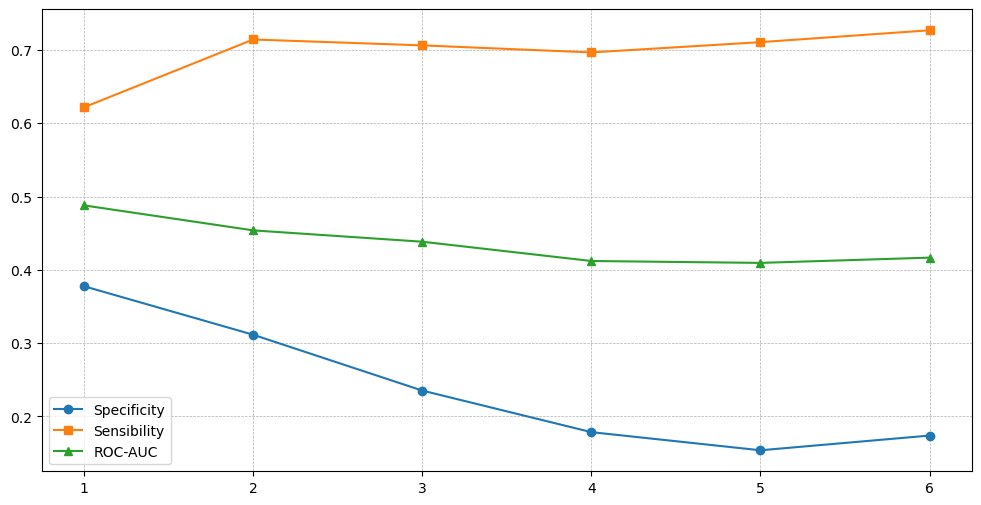

In [10]:
for i in range(len(folders)):
    y_test = np.load("../0_Data/splits/E" +str(idx_exp)+ "/"  + folders[i] + "/y_test_tensor.npy")
    y_test_df = pd.DataFrame(y_test)
        
    y_pred = y_pred_by_split[i]
    n1 = int(y_pred.shape[0]/timeStep)
    y_pred = y_pred.reshape(n1, timeStep)
    y_pred_df = pd.DataFrame(y_pred)

    df_metrics = get_metrics_over_time(timeStep, y_test_df, y_pred_df)
    plot_metrics_over_time(df_metrics, timeStep)
    break